In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test-unbalanced.csv', 'train-balanced-sarcasm.csv', 'test-balanced.csv']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [4]:
path = Path('../input/')
path.ls()

[PosixPath('../input/test-unbalanced.csv'),
 PosixPath('../input/train-balanced-sarcasm.csv'),
 PosixPath('../input/test-balanced.csv')]

In [5]:
df = pd.read_csv(path/'train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
df['comment'][1]

'You do know west teams play against west teams more than east teams right?'

In [7]:
#data = TextDataBunch.from_csv(path, 'train-balanced-sarcasm.csv', num_workers=0)

Creating our data failed because our csv had NaN values in our comments column.  We will have to sanitize our dataframe first.  df.dropna() will drop all rows with NaNs (df.dropna(1) will drop all columns.  By default, the parameter value is 0 for rows).

In [8]:
badinputs = df.loc[lambda x: x['comment'].isna()]
badinputs.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
56269,1,NaN,SodokuIRL,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a sh..."
68590,1,NaN,TossTheDog,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should p...
135348,0,NaN,So12rovv,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,Khvostov_7g-02,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,PeaceLovePositivity,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your ki..."


In [9]:
df = df.dropna()
df['comment'][56267:56270]

56267    Climate change since its a hoax by the chinese
56268    Clearly a gummy bear since he's u/EdibleFriend
56270                                           SELLOUT
Name: comment, dtype: object

In [10]:
random_seed(123,True)
rand_df = df.assign(is_valid = np.random.choice(a=[True,False],size=len(df),p=[0.2,0.8]))
rand_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,is_valid
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",False
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,False
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,False
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,False
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,False


In [11]:
random_seed(1006,True)
bs=48
data_lm = (TextList.from_df(rand_df, path, cols="comment")
                .split_from_df(col='is_valid')
                .label_for_lm()
                .databunch(bs=bs))

In [12]:
data_lm.save('../working/data_lm.pkl')

In [13]:
data_lm = load_data('../working','data_lm.pkl',bs=bs)
data_lm.show_batch()

idx,text
0,"could use one of those tools . xxbos i do n't pay attention to her , but as long as she 's legal i would n't kick her out of bed ( before she took a load ) xxbos xxmaj trick or treating in general is just weird ... xxbos xxmaj blade xxunk or xxup gtfo ! xxbos xxmaj you do n't have to , you have a good build"
1,"xxmaj bush or xxmaj regan . xxbos xxmaj you 've got a separate , meat free grill for my vegan tofu and black bean burgers , right ? xxbos xxmaj this is what i remember as well . xxbos xxmaj damn censorship xxbos xxmaj all projects will require xxunk doffs . xxbos 100 % dead or paid off before he can testify . xxbos xxmaj but just think man ,"
2,"bit xxunk . xxbos xxup kkk confirmed xxbos xxmaj but xxmaj god will provide new jobs to this most blessed state , right ? xxbos xxmaj you 're a good xxmaj canadian . xxbos xxmaj it makes perfect sense in xxmaj french , stop stealing our words ! xxbos xxmaj same i usually get high before i go to work , drive , watch children , lift weights , etc"
3,"the website into 2 different sections for xxmaj vanilla and xxup tbc so people do n't get confused with the different guides / macros / addons etc xxbos xxmaj love in action xxbos tell yo mom ? xxbos xxmaj germans , always praktisch und logisch xxbos xxmaj this is likely , but also would show up in a packet capture xxbos xxup r5 : xxmaj the text box describing '"
4,"i 'm sure the xxmaj trump family really needs the money . xxbos xxmaj it 's not * real * xxunk because that 's never been tried ! xxbos i read this as pom xxbos i am also jumping on board . xxbos xxmaj worst part is , the co - pilot does n't get the money he won because the pilot died xxbos xxmaj which jobs do you think"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


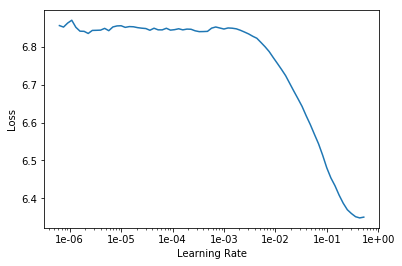

In [14]:
random_seed(100,True)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [15]:
random_seed(111, True)
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.842551,4.682385,0.256253,10:28


In [16]:
learn.save('fit_head')

In [17]:
learn.load('fit_head');

In [18]:
learn.unfreeze()

In [19]:
random_seed(444,True)
learn.fit_one_cycle(10,2e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.398282,4.336180,0.287431,11:46
1,4.461118,4.390730,0.281399,11:48
2,4.455595,4.393912,0.282267,11:47
3,5.302433,5.187678,0.210693,11:47
4,4.652827,4.583492,0.265925,11:46
5,4.494668,4.419921,0.279902,11:45
6,4.380002,4.322913,0.288808,11:45
7,4.278059,4.246073,0.295592,11:45
8,4.181246,4.203826,0.300263,11:47
9,4.114702,4.197618,0.301132,11:47


In [20]:
learn.save('fine_tuned')

In [21]:
learn.load('fine_tuned');

In [22]:
learn.save_encoder('fine_tuned_enc')

In [23]:
data_clas = (TextList.from_df(rand_df, vocab=data_lm.vocab, cols="comment")
                .split_from_df(col='is_valid')
                .label_from_df(cols='label')
                .databunch(bs=bs))
data_clas.save('../working/data_clas.pkl')

In [24]:
data_clas = load_data('../working','data_clas.pkl',bs=bs)
data_clas.show_batch()

text,target
xxbos * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc,0
"xxbos i 'm all for getting people out of their comfort zones and learning how to be adults , but i can think of much better ways of doing that than a forced 2 year xxunk , like going to college , taking a summer job ( i installed alarm systems for 2 summers on the xxmaj east xxmaj coast , that taught me more about how to work with",0
"xxbos i believe i 've seen people attacked for potentially supporting trump , i believe people have expressed a far left wing opinion with authoritarian furor because of trump 's campaign xxrep 4 . xxmaj but i have n't seen how the city of xxunk huge liberal city in a left leaning state ) was affected to the point of protest boarding on the level of riot .",0
xxbos a few reasons ; xxmaj to try and get bound to another server sitting development / testing at work xxmaj to view email / accounts without logging out of my main ones xxmaj to check email / other things on someone else 's computer so they do n't have to log out of their stuff xxmaj probably use it for the first case most often .,0
"xxbos xxmaj your right , a system that is totally xxunk on where you happen to queue up , leaving you unable to do anything about it ( even to the point of making it easier for the hospital to take care of other people ) is totally superior to the xxunk system of allowing ones hard work have an impact on treatment .",1


In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


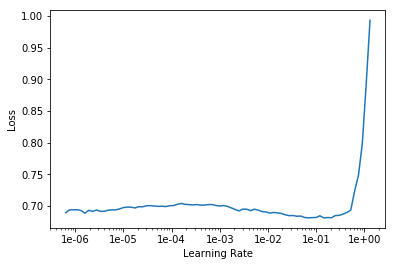

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
random_seed(678,True)
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.590022,0.550406,0.715907,06:19


In [28]:
learn.save('first')

In [29]:
learn.load('first');

In [30]:
random_seed(777,True)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.539054,0.505362,0.750015,07:02


In [31]:
learn.save('second')

In [32]:
learn.load('second');

In [33]:
random_seed(999,True)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.534017,0.494987,0.756450,10:09


In [34]:
learn.save('third')

In [35]:
learn.load('third');

In [80]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.510807,0.492427,0.759064,14:41
1,0.502714,0.490102,0.760777,13:56


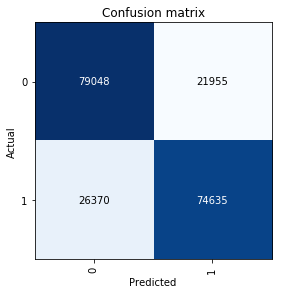

In [81]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix()

In [95]:
losses,idxs = interp.top_losses()
len(data_clas.valid_ds)==len(losses)==len(idxs)
idxs[:10]

tensor([ 18455,  37050,  12987, 180591, 136775, 176705, 122041,  69016,  53152,
           733])

In [116]:
for i in range(10):
  print(df['comment'][idxs[i]],df['label'][idxs[i]],losses[i])

She also WOO'd a lot 0 tensor(7.3346)
Terrific xox 0 tensor(6.8118)
Citation 0 tensor(6.2847)
**Fagin:** the leader of the boy beggars in "*Oliver Twist*" by Charles Dickens. 0 tensor(6.0212)
Chase Daniel trade incoming. 1 tensor(5.7040)
alright im tapped man sorry 0 tensor(5.5542)
This is why the car insurance is so expensive in California. 1 tensor(5.5522)
*tips fedora* m'lady 1 tensor(5.3699)
Please remove the helmet and then I can render an opinion. 0 tensor(5.2587)
He can draw it up so all you have to do is date it and mail it 0 tensor(5.2510)


In [86]:
# Sarcastic
learn.predict("What could possibly go wrong?")

(Category 1, tensor(1), tensor([0.0192, 0.9808]))

In [85]:
# Sincere
learn.predict("I think that is a really good idea.")

(Category 0, tensor(0), tensor([0.8771, 0.1229]))

In [83]:
# Sarcastic
learn.predict("Obviously this is all your fault.")

(Category 1, tensor(1), tensor([0.0173, 0.9827]))

In [87]:
# Sincere
learn.predict("Honestly, this is your fault.")

(Category 1, tensor(1), tensor([0.4581, 0.5419]))

In [89]:
# ???
learn.predict("Good job, learner!")

(Category 0, tensor(0), tensor([0.5364, 0.4636]))